# Statements

Esta tabla contiene la información de las sentencias.  --> ABEL COMPLETAR <--

## 1 - Obtencion de datos

In [1]:
import matplotlib.pyplot as plt
from notebooks_utils import *

full_table = get_data('statements')

# Table name, features and target.
TABLE_NAME = 'statements'
TABLE_FEATURES = ['statement__category', 'statement__parent', 'statement__statement_role', 'statement__first_child_category','statement__second_child_category','statement__third_child_category', 'statement__height', 'statement__depth', 'statement__has_or_else', 'statement__body_size', 'statement__expertise_level']
TABLE_TARGET = 'statement__expertise_level'

# Load features and target.
X, y = full_table[TABLE_FEATURES], full_table[[TABLE_TARGET]].iloc[:,0]

# Print information about the loaded table.
print(f'Features shape: {X.shape}')
print(f'Target shape: {y.shape}')

print(f'As we can see the downloaded data contains a total of {X.shape[0]} instances. Each of the instances corresponds to a program. For each program we have {X.shape[1]} attributes.')

2024-05-26 19:48:07.696869 Data cache files found ...
2024-05-26 19:48:08.274171 Data cache files successfully loaded!!
Features shape: (619667, 11)
Target shape: (619667,)
As we can see the downloaded data contains a total of 619667 instances. Each of the instances corresponds to a program. For each program we have 11 attributes.


## 2 - Exploracion de datos

Una vez tenemos nuestra tabla en un dataframe el siguiente paso es explorarla para ver qué tipo de información contiene.

In [2]:
print(X.info())
print('=============')
print(y.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 619667 entries, 0 to 619666
Data columns (total 11 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   statement__category               619667 non-null  object 
 1   statement__parent                 619667 non-null  object 
 2   statement__statement_role         619667 non-null  object 
 3   statement__first_child_category   549453 non-null  object 
 4   statement__second_child_category  333827 non-null  object 
 5   statement__third_child_category   3605 non-null    object 
 6   statement__height                 619667 non-null  int64  
 7   statement__depth                  619667 non-null  int64  
 8   statement__has_or_else            163466 non-null  object 
 9   statement__body_size              168689 non-null  float64
 10  statement__expertise_level        619667 non-null  object 
dtypes: float64(1), int64(2), object(8)
memory usage: 52.

Cómo podemos ver la tabla está compuesta por 3 variables numéricas y 9 de tipo objeto.

### 2.1 - Balance de clases

In [3]:
instances_for_class_low = len(full_table[full_table[TABLE_TARGET] == "BEGINNER"])
instances_for_class_high = len(full_table[full_table[TABLE_TARGET] == "EXPERT"])

print(f"The dataset contains {instances_for_class_low/len(full_table)*100:.4}% instances for BEGINNER class and {instances_for_class_high/len(full_table)*100:.4}% for EXPERT class.")

The dataset contains 73.83% instances for BEGINNER class and 26.17% for EXPERT class.


### 2.2 - Duplicados
Miramos si la tabla tiene entradas duplicadas.

In [4]:
number_of_duplicated_entries = sum(full_table.duplicated(subset=TABLE_FEATURES + [TABLE_TARGET]))
duplicated_entries_pct = number_of_duplicated_entries / len(full_table) * 100
print(f"The dataset contains [{duplicated_entries_pct:.4}%] of duplicated entries.")

The dataset contains [94.73%] of duplicated entries.


### 2.3 - Valores Nulos 
Miramos si alguna de las variables que contiene la tabla contiene algún valor que sea nulo.

In [5]:
X.isnull().sum()

statement__category                      0
statement__parent                        0
statement__statement_role                0
statement__first_child_category      70214
statement__second_child_category    285840
statement__third_child_category     616062
statement__height                        0
statement__depth                         0
statement__has_or_else              456201
statement__body_size                450978
statement__expertise_level               0
dtype: int64

Los nulos se deben a que esos campos solo son aplicables para ciertas categorias

In [6]:
print_empty_cols(X)

statement__category
-------------------
0 instancias no tienen un valor para la columna statement__category


statement__parent
-----------------
0 instancias no tienen un valor para la columna statement__parent


statement__statement_role
-------------------------
0 instancias no tienen un valor para la columna statement__statement_role


statement__first_child_category
-------------------------------
0 instancias no tienen un valor para la columna statement__first_child_category


statement__second_child_category
--------------------------------
0 instancias no tienen un valor para la columna statement__second_child_category


statement__third_child_category
-------------------------------
0 instancias no tienen un valor para la columna statement__third_child_category


statement__height
-----------------
0 instancias no tienen un valor para la columna statement__height


statement__depth
----------------
0 instancias no tienen un valor para la columna statement__depth


statement__h

### 2.4 - Describimos los valores de las variables de la tabla.

In [7]:
np.transpose(X.describe(percentiles=[.25, .50, .75], include = ['object', 'float', 'bool', 'int']))

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
statement__category,619667,21,AssignmentStmt,284417,NaN,NaN,NaN,NaN,NaN,NaN,NaN
statement__parent,619667,11,FunctionDef,242457,NaN,NaN,NaN,NaN,NaN,NaN,NaN
statement__statement_role,619667,20,MethodDefBody,143732,NaN,NaN,NaN,NaN,NaN,NaN,NaN
statement__first_child_category,549453,32,Variable,284720,NaN,NaN,NaN,NaN,NaN,NaN,NaN
statement__second_child_category,333827,33,Call,138949,NaN,NaN,NaN,NaN,NaN,NaN,NaN
statement__third_child_category,3605,25,Call,1299,NaN,NaN,NaN,NaN,NaN,NaN,NaN
statement__height,619667.0,NaN,NaN,NaN,3.402624,2.175689,1.0,2.0,3.0,4.0,54.0
statement__depth,619667.0,NaN,NaN,NaN,2.90816,2.167262,0.0,1.0,3.0,4.0,82.0
statement__has_or_else,163466,2,False,120978,NaN,NaN,NaN,NaN,NaN,NaN,NaN
statement__body_size,168689.0,NaN,NaN,NaN,1.87605,2.36428,1.0,1.0,1.0,2.0,276.0


Vamos a discretizar las variables numericas, agrupando conjuntos de valores en categorias, para hacer un análisis de los datos. Para cada variable es necesaario ver la distribucion de lo valores para hacer los bins (categorias).

In [8]:
# DISCRETIZATION
X_copy = X.copy()

discretized_columns = {
    "statement__depth": [(0.0, 1.0), (1.0, 3.0), (3.0, 4.0), (4.0, inf)],  # min: 0.0 max: 82.0
    "statement__height": [(0.0, 2.0), (2.0, 3.0), (3.0, 4.0), (4.0, inf)],  # min: 1.0 max: 54.0
    "statement__body_size": [(-1.0, 1.0), (1.0, 2.0), (2.0, inf)],  # min: 1.0 max: 276
}

discretize_columns(X_copy, discretized_columns)
    
# SINGLE FEATURE
print("--- SINGLE FEATURE ---")
print(get_statistics(X_copy, ['statement__depth'], 10))
print(get_statistics(X_copy, ['statement__height'], 10))
print(get_statistics(X_copy, ['statement__body_size'], 10))
print(get_statistics(X_copy, ['statement__category'], 10))
print(get_statistics(X_copy, ['statement__first_child_category'], 10))
print(get_statistics(X_copy, ['statement__second_child_category'], 10))
print(get_statistics(X_copy, ['statement__third_child_category'], 10))
print(get_statistics(X_copy, ['statement__parent'], 10))
print(get_statistics(X_copy, ['statement__statement_role'], 10))
print(get_statistics(X_copy, ['statement__has_or_else'], 10))


# 2 FEATURES
print("--- TWO FEATURES ---")
#print(get_statistics(X_copy, ['module__function_defs_pct', 'module__number_of_classes'], 10))

# 3 FEATURES
print("--- THREE FEATURES ---")
#print(get_statistics(X_copy, ['module__class_defs_pct', 'module__function_defs_pct', 'module__enum_defs_pct'], 10))

--- SINGLE FEATURE ---
statement__depth  count  percentage
       [1.0_3.0) 227401   36.697291
       [4.0_inf] 196859   31.768514
       [3.0_4.0) 135996   21.946626
       [0.0_1.0)  59411    9.587569

statement__height  count  percentage
        [4.0_inf] 224825   36.281583
        [3.0_4.0) 203659   32.865878
        [2.0_3.0) 115526   18.643239
        [0.0_2.0)  75657   12.209300

statement__body_size  count  percentage
             unknown 450978   72.777476
           [1.0_2.0) 103974   16.779012
           [2.0_inf]  64715   10.443512

statement__category  count  percentage
     AssignmentStmt 284417   45.898362
                 If 117366   18.940173
             Return  70637   11.399187
                For  27884    4.499836
         ImportFrom  27882    4.499513
             Import  16471    2.658041
AugmentedAssignment  14220    2.294781
              Raise  13362    2.156319
                Try  10803    1.743356
             Assert   7937    1.280849

statement__first_ch

In [9]:
def normalize_datatypes(X:pd.DataFrame, y:pd.Series) -> (pd.DataFrame, pd.Series, [str]):
    X = pd.get_dummies(X)
    X = X.astype('float32')
    y = y.apply(lambda value: 0 if value == "BEGINNER" else 1) # EXPERT will be 1 and BEGINNER will be 0.
    y = y.astype('float32')
    columns_names = X.columns.tolist()
    return X, y, columns_names

X, y, TABLE_FEATURES = normalize_datatypes(X, y)
# Print information about the loaded table
print(f'Features shape: {X.shape}')
print(f'Target shape: {y.shape}')

Features shape: (619667, 149)
Target shape: (619667,)


#### Muestra la matriz de correlación de pearson entre las variables de la tabla.

<Axes: >

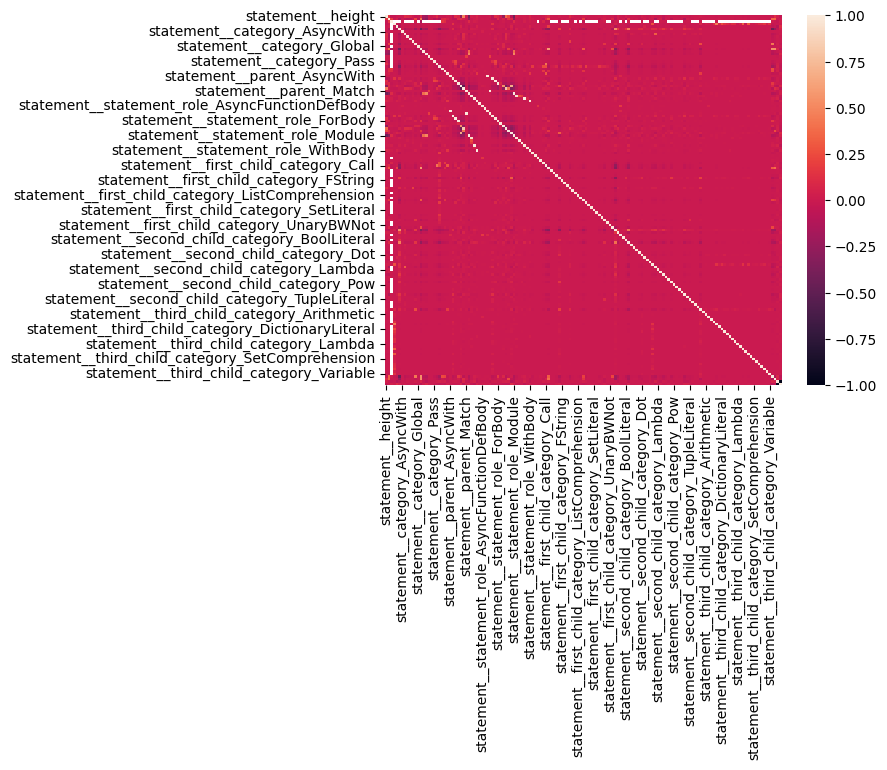

In [10]:
sns.heatmap(X.corr(), annot=False)

Se aprecian muchas relaciones pero habrá que mirar como mejorar este diagrama para que sea legible

## 3 - Detección de valores atípicos (outliers)
Una vez sabemos qué datos contiene la tabla, analizaremos los valores que toma cada una de las variables de cada instancia. El objetivo es identificar posibles valores atípicos que nos dificulten la realización de futuras tareas. 
Tras su análisis, se puede concluir que un valor:
    - **Es erróneo**. En este caso hay que tomar una decisión para cada caso, siendo los tratamientos más extendidos son listwise, pairwise, drop variables, mean/median imputation, most frequent, separate category, zero imputation, cold deck, hot deck,(stochastic) regression, k-NN and multiple imputation. Los resultados de imputación regresiva, k-NN y múltiple dan buenos resultados, aunque, como se ha indicado, es necesario el estudio en cada caso.
    - **Es correcto, pero anómalo**. Se documenta su existencia para su posible discusión y se mantiene en el dataset. En estos casos se hace necesaria la utilización de algoritmos y estadísticos que no sean muy sensibles a dichos valores anómalos.

## Univariate
Para cada uno de los atributos se debe realizar un análisis y detección de valores atípicos, estudiando su posible causa. 
Existen diversas formas de calcular los valores anómalos. 

### Variables numéricas
Para las variables numéricas, se suele identificar: 
    - a) Valor atípico leve es el que está fuera de $[Q1 - 1.5IQR, Q3 + 1.5IQR]$, donde $IQR = Q3-Q1$.
    - b) Valor atípico extremo está fuera de $[Q1 - 3IQR, Q3 + 3IQR]$.

La idea es probar con a) y si hay pocas instancias analizarlas. Si hubiese muchas, mirar b) y analizar si fuesen pocas. No hay un algoritmo o método estipulado, puesto que depende del dominio del problema y de los datos.

Los límites de Tukey se basan en los cuartiles de los datos y son sensibles a la presencia de sesgo en la distribución. Cuando hay asimetría en los datos, los límites de Tukey pueden no ser tan efectivos para identificar outliers de manera equitativa en ambos extremos de la distribución. El Coeficiente de Medcouple es útil para identificar la asimetría en los datos, especialmente en presencia de valores atípicos o sesgados. Es una medida robusta porque no se ve tan afectada por valores extremos como la media y la desviación estándar. El MC puede proporcionar información adicional sobre la asimetría de la distribución, lo que te permite ajustar los límites de Tukey de manera más apropiada para tu conjunto de datos específico. Una posible variacion de los límites de Tukey teniendo en cuenta MC podria ser: 
   - Si MC es mayor que 0 (asimetría hacia la derecha):
      - low = (q1-1.5 * math.exp(-4*mc) * iqr)
      - high = (q3+1.5 * math.exp(3.5*mc) * iqr)
   - Si la asimetriza es hacia la izquierda:    
      - low = (q1-1.5 * math.exp(-3.5*mc) * iqr)
      - high = (q3+1.5 * math.exp(4*mc) * iqr)


### Variables categóricas
Para las variables categóricas no existe el concepto de valor anómalo, pero sí se puede considerar en base a un análisis de frecuencia. Por ejemplo, que el uso de una categoría sea residual, pudiendo tener un 0.1% de instancias en el dataset. Para detectar estos valores, se puede fijar un valor mínimo de frecuencia en función del número posible de valores de la variable categórica (2 en el caso de una variable booleana). Por ejemplo, un umbral de $\frac{0.2\%}{valores}$ (0.1% en el caso de una variable booleana)

## Analisis detallado de variables
Para cada una de las 7 variable (1 booleanas, 3 numericas y 3 categóricas) se hara un analisis detallado 

### Variable has_or_else (1/10)
Esta variable es de tipo booleano y representa si ciertas categorias de statements tienen la clausula else. El primer paso es hacer un análisis visual de como se distribuyen los valores de la variable.

KeyError: 'statement__has_or_else'

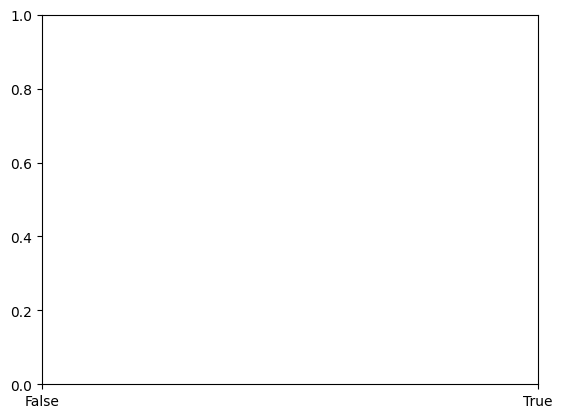

In [11]:
plt.xticks([0, 1], ['False', 'True'])
sns.histplot(X['statement__has_or_else'], discrete=True)

In [ ]:
num_true_values = len(X[X['statement__has_or_else'] == True])
num_false_values = len(X[X['statement__has_or_else'] == False])
std = X['statement__has_or_else'].std()
freq_true = len(X[X['statement__has_or_else'] == True]) / len(X['statement__has_or_else'])
freq_false = len(X[X['statement__has_or_else'] == False]) / len(X['statement__has_or_else'])
print(f'La variable has_or_else contiene {num_true_values} valores verdaderos y {num_false_values} valores falsos. Y, la desviación típica es de {std}')
print(f'La frecuencia con la que programa puede tener la variable has_or_else a True es {freq_true}.')
print(f'La frecuencia con la que programa puede tener la variable has_or_else a False es {freq_false}.')

No suma el 100% debido a los valores nulos

In [ ]:
possible_values = [True, False]
print_frequency_anal_for_cat_var(X, 'statement__has_or_else', possible_values)

In [ ]:
X[X['statement__has_or_else'] == True].describe(percentiles=[.25, .50, .75], include = ['object', 'float', 'bool', 'int'])


### Variable height (2/10)
Esta variable representa la distancia del statement al root del módulo (fichero). Como vimos en la descripción de la tabla esta varibale adopta valores en el rango 1 - 54. Con una media de 3.176.

In [ ]:
sns.stripplot(X['statement__height'])

In [ ]:
print_outliers_for_df_column(X, 'statement__height')

In [ ]:
X[X['statement__height'] > 10].describe(percentiles=[.25, .50, .75], include = ['object', 'float', 'bool', 'int'])

### Variable depth (3/10)
Esta variable representa la distancia desde el statement hasta una hoja del ast. Como vimos en la descripción de la tabla esta varibale adopta valores en el rango 0 - 82. Con una media de 2.8496.

In [ ]:
sns.stripplot(X['statement__depth'])

In [ ]:
print_outliers_for_df_column(X, 'statement__depth')

In [ ]:
X[X['statement__depth'] > 13].describe(percentiles=[.25, .50, .75], include = ['object', 'float', 'bool', 'int'])

### Variable body_size (4/10)
Esta variable representa el número de sentencias o expresiones que se definen dentro del cuerpo de ciertas categorías de sentencias. Como vimos en la descripción de la tabla esta varibale adopta valores en el rango 1 - 276. Con una media de 1.8938.

In [ ]:
sns.stripplot(X['statement__body_size'])

In [ ]:
print_outliers_for_df_column(X,'statement__body_size')

In [ ]:
X[X['statement__body_size'] > 50].describe(percentiles=[.25, .50, .75], include = ['object', 'float', 'bool', 'int'])

### Variable category (5/10)
Esta variable es de tipo categórica y representa el tipo de sentencia.

In [ ]:
sns.catplot(full_table['statement__category'], kind="count")

In [ ]:
print_frequency_anal_for_cat_var(full_table, 'statement__category')

### Variable parent (6/10)
Esta variable es de tipo categórica y representa el tipo del padre de la sentencia.

In [ ]:
sns.catplot(full_table['statement__parent'], kind="count")

In [ ]:
print_frequency_anal_for_cat_var(full_table, 'statement__parent')

### Variable statement_role (7/10)
Esta variable es de tipo categórica y representa el rol que representa la sentencia en su padre.

In [ ]:
sns.catplot(full_table['statement__statement_role'], kind="count")

In [ ]:
print_frequency_anal_for_cat_var(full_table, 'statement__statement_role')

### Variable first_child_category (8/10)
Esta variable es de tipo categorica y representa la categoria del primer hijo de la sentencia.

In [ ]:
sns.catplot(full_table['statement__first_child_category'], kind="count")

In [ ]:
print_frequency_anal_for_cat_var(full_table, 'statement__first_child_category')

### Variable second_child_category (9/10)
Esta variable es de tipo categorica y representa la categoria del segundo hijo de la sentencia.

In [ ]:
sns.catplot(full_table['statement__second_child_category'], kind="count")

In [ ]:
print_frequency_anal_for_cat_var(full_table, 'statement__second_child_category')

### Variable third_child_category (3/9)
Esta variable es de tipo categorica y representa la categoria del tercer hijo de la sentencia.

In [ ]:
sns.catplot(full_table['statement__third_child_category'], kind="count")

In [ ]:
print_frequency_anal_for_cat_var(full_table, 'statement__third_child_category')